In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML

# Bayesian Testing

```{margin}
These sections continue to draw on [Think Bayes](https://greenteapress.com/wp/think-bayes) by Allen B. Downey.
```

In statistical hypothesis testing, we compute a *p*-value and use it to determine whether the results are “statistically significant”.

Today we'll learn about the Bayesian alternative, called **Bayesian Hypothesis Testing.**

## The Euro Problem (again)

In _Information Theory, Inference, and Learning Algorithms,_ David MacKay posed this problem:

"A statistical statement appeard in _The Guardian_ on Friday, January 4, 2002:

> When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110.  'It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics. 'If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7\%.'

But do these data give evidence that the coin is biased rather than fair?"


### Where we got last time

We used the data to estimate the probability of heads *p* starting with either a uniform or informative prior (and observed that the data swamped the prior). 

We calculated the probability using a single update based on the binomial distribution:

$$ P(p\,\vert\,\text{Data}) = \frac{ \text{Prior for }p \cdot \text{Binomial}_p(140, 250)}{\text{Normalizer}} $$


And in code:

In [2]:
from scipy.stats import randint
from scipy.stats import binom

# our usual update function
def update(distribution, likelihood):
    distribution['probs'] = distribution['probs'] * likelihood
    prob_data = distribution['probs'].sum()
    distribution['probs'] = distribution['probs'] / prob_data
    return distribution

# start with uniform prior
p_dist = pd.DataFrame(index = np.arange(101)/100)
p_dist['probs'] = randint(0, 101).pmf(np.arange(101)) 

# compute whole-data likelihoods
likelihood = [binom.pmf(140, 250, p) for p in p_dist.index]

update(p_dist, likelihood);

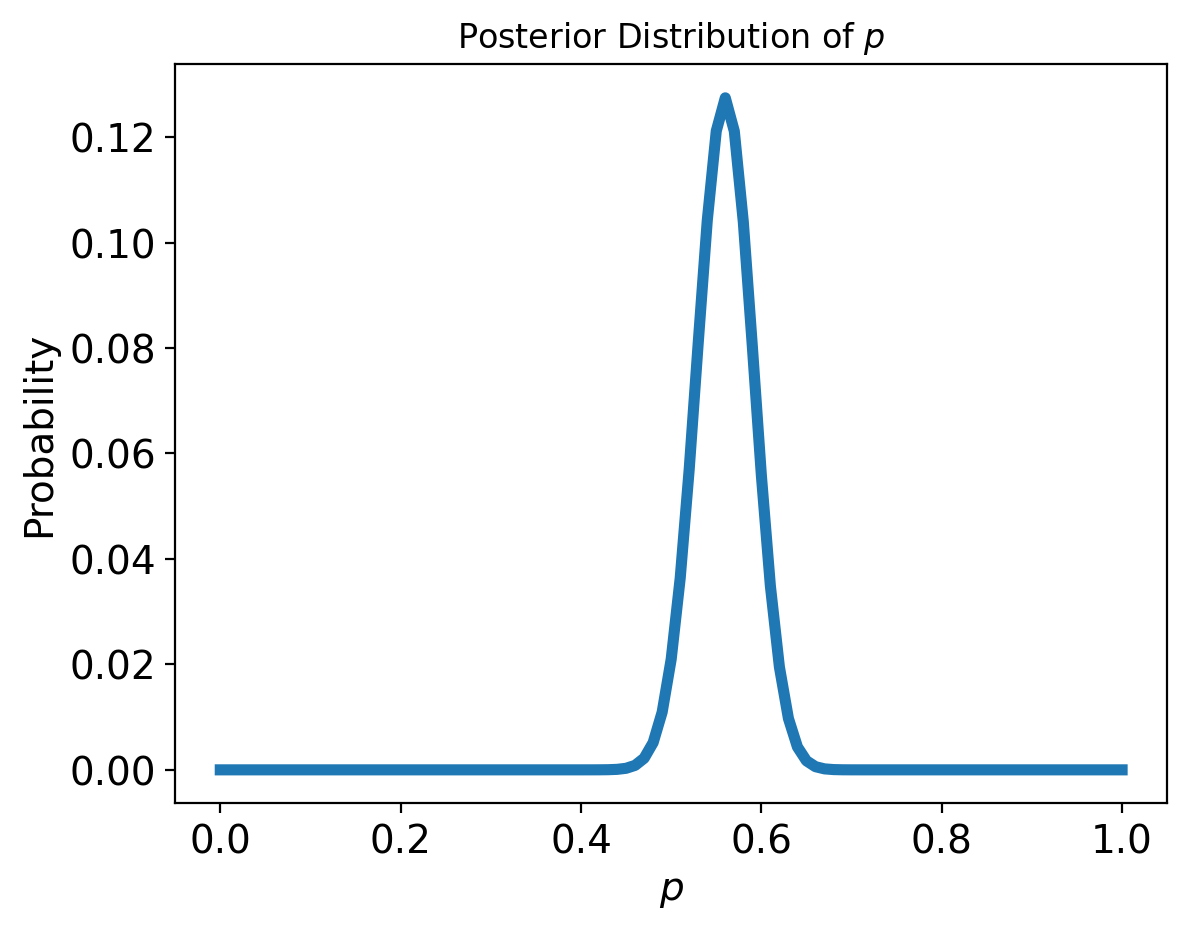

In [3]:
p_dist.plot(lw = 4, legend = False, title = 'Posterior Distribution of $p$', fontsize = 14)
plt.xlabel('$p$', size = 14)
plt.ylabel('Probability', size = 14);

So we observed that the posterior mean is about 0.56, with a 90% credible interval from 0.51 to 0.61.

But we never actually answered the question: “Do these data give evidence that the coin is biased rather than fair?”

We know how to answer this question directly in frequentist land already. We assume the coin is fair and test the probability of observing the data under that assumpion:

In [4]:
#test both tails
1-binom.cdf(140-1, 250, p=0.5)+binom.cdf(110, 250, p=0.5)

0.06642115124004327

And so indeed 'If the coin were unbiased, the change of getting a result as extreme as that would be less than 7%.'

But how do we answer this question in the Bayesian world?

### Uniformly Distributed Bias

Suppose “biased” means that the probability of heads is anything except 50%, and all other values are equally likely.

We can represent that definition by making a uniform distribution and removing 50%.

In [5]:
# start with uniform distribution
p_dist = pd.DataFrame(index = np.arange(101)/100)
p_dist['probs'] = randint(0, 101).pmf(np.arange(101)) 

#bias it
biased_uniform = p_dist.copy()
biased_uniform['probs'][.5] = 0
biased_uniform['probs'] = biased_uniform['probs']/sum(biased_uniform['probs']) #normalize it

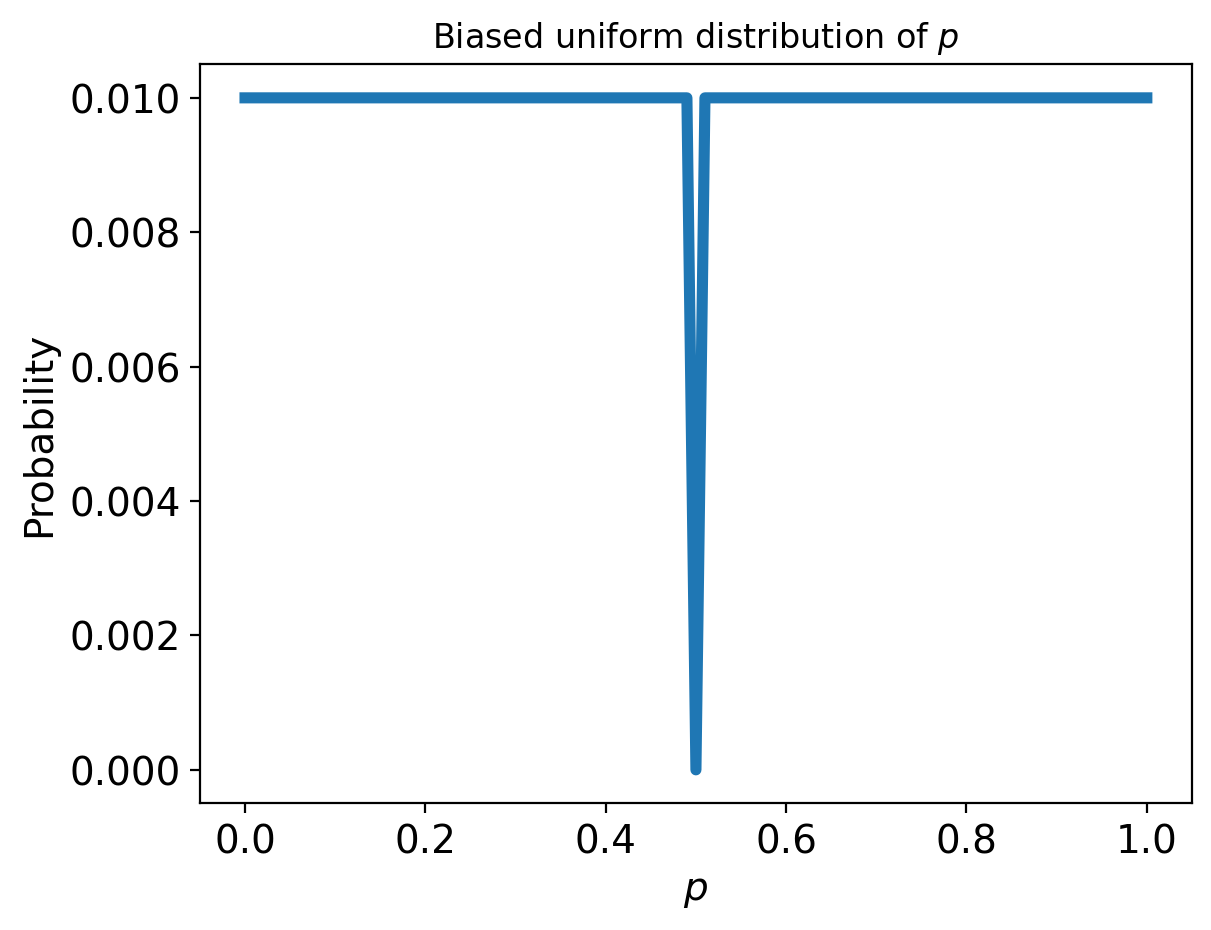

In [6]:
biased_uniform.plot(lw = 4, legend = False, title = 'Biased uniform distribution of $p$', fontsize = 14)
plt.xlabel('$p$', size = 14)
plt.ylabel('Probability', size = 14);

Now we can calculate the likelihood of our data given this biased distribution. This means we need to calculate the probability of the data if the coin is biased. To calculate the probability of the data we compute the probability of the data given each value of p (i.e. P(D|p)), then sum those conditional probabilities times the individual probabilities p.

In [7]:
likelihood_vector = [binom.pmf(140, 250, p) for p in p_dist.index]
likelihood = np.sum(biased_uniform['probs'] * likelihood_vector)
likelihood

0.0039004919277707334

If we were to just assume a standard binomial distribution, we can directly calculate the likelihood of observing our data as well:

In [9]:
binom.pmf(140, 250, p=0.5)

0.008357181724918204

So now we have the probability of the data under a "biased uniform hypothesis" (for some definition of biased that we invented) and the probability of the data under the fair hypothesis.

### Bayes Factors

In Bayesian inference we often consider the probability of data under two hypotheses (let's say hypothesis A and B). In order to compare the hypotheses we look at the **ratio of their likelihoods** (i.e. the ratio of the probability of the data under each hypothesis). This is called the **Bayes factor**, often denoted $K$, which has the desirable property of being independent of any prior probability:


$$ K = \frac{P(D|A)}{P(D|B)} $$


In our case, the Bayes factor is:


$$ K = \frac{P(D|\text{fair})}{P(D|\text{biased uniform})} = 0.0084/0.0039 = 2.14$$


So you could say the data are about two times more likely if the coin is fair than if it is biased, by this definition of “biased”.

We can actually use Bayes' rule to convert Bayes factors to posterior probability (you can derive this for yourselves). In this case we need to have some prior belief in each hypothesis (note: this is our prior belief in whether the coin is fair or not, not the prior distribution of values for p). Let's say our prior belief that the coin was fair was 50%. Then we can say:


$$ P(\text{fair|data}) = \frac{K*P(\text{fair})}{K*P(\text{fair}) + 1-P(\text{fair})} = \frac{(2.14)(0.5)}{(2.14)(0.5)+(1-0.5)} = 0.68$$

So we could say that the the data moved us from thinking there was a 50/50 chance of the coin being fair to a 68% chance. Evidence that “moves the needle” from 50% to 68% is not very strong.

We could do the same exercise with other definitions of "biased", but in most cases you'll see that the evidence doesn't seem very convicing from a Bayesian point of view.

### Bayesian Hypothesis Testing

```{margin}
Following the discussion in [Think Bayes](https://greenteapress.com/wp/think-bayes) by Allen B. Downey.
```

A Bayesian alternative to *p*-values is to report the Bayes factor K, which summarizes the strength of the evidence in favor of one hypothesis or the other.

While K doesn't depend on the prior probability (an advantage over just reporting the posterior), it does depend on our definition of the hypothesis.

In the end though, is it really that useful to make a decision if a coin is biased? 

Or maybe it is more useful to ask questions such as: 

>**Prediction:** Based on what we know about the coin, what should we expect to happen in the future?



>**Decision-making:** Can we use those predictions to make better decisions?


We already saw prediction applied in the World Cup example. We generated a "posterior predictive distribution" to predict which team would win a rematch. Next, we'll look at an example of making decisions based on our predictions.

## Bayesian Decision Making: The Bayesian Bandits Problem

A slot machine is sometimes called a “one-armed bandit."


```{margin} 
Image credit: Stable Diffusion, prompt: "Photorealistic bandit with one arm playing a slot machine"
```

<center>
    
<img src="images/Stable-Diffusion-photorealistic-bandit-one-arm-playing-slot-machine.jpg" width="400px">
    
</center>

### Bayesian Bandit Strategy

Suppose that each time you play a slot machine, there is a fixed probability that you win. And suppose that different machines give you different probabilities of winning, but you don’t know what the probabilities are.

Initially, you have the same prior belief about each of the machines, so you have no reason to prefer one over the others. But if you play each machine a few times, you can use the results to estimate the probabilities. And you can use the estimated probabilities to decide which machine to play next.

This is called the Bayesian bandit strategy.

If we know nothing about the probability of winning, we can start with a uniform prior. Supposing we are choosing from four slot machines, so we'll make four copies of the prior, one for each machine.

In [10]:
p_dist = pd.DataFrame(index = np.arange(101)/100)
p_dist['probs'] = randint(0, 101).pmf(np.arange(101))

beliefs = [p_dist.copy() for i in range(4)]

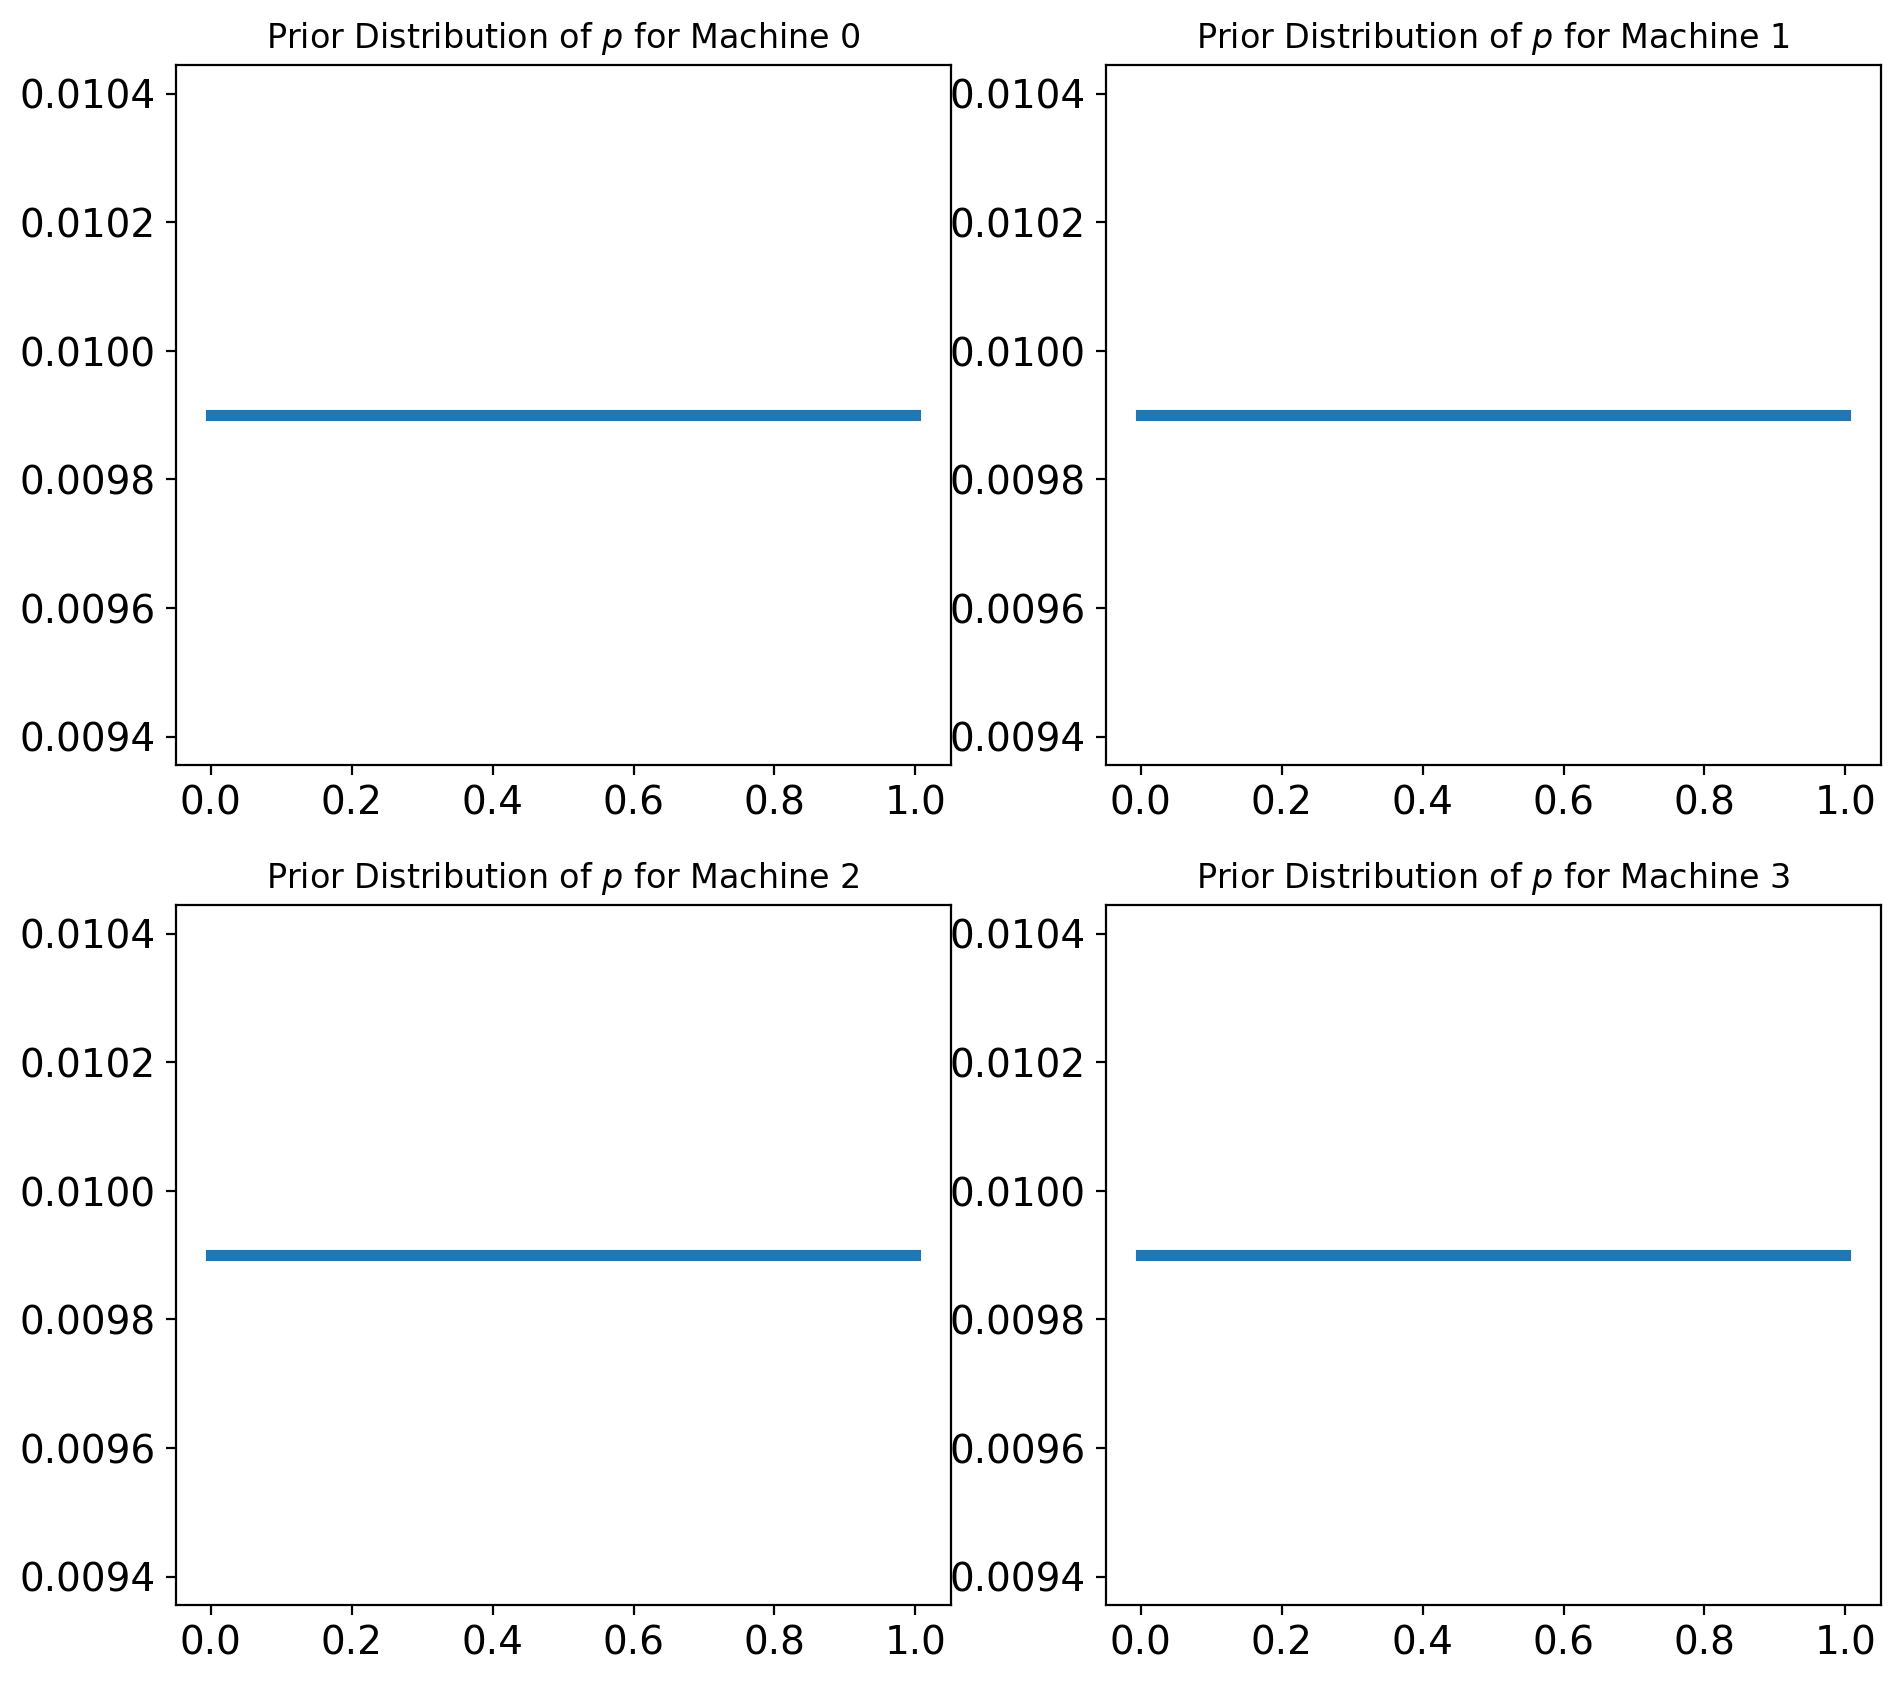

In [11]:
plt.figure(figsize=(11, 10))
for i, pmf in enumerate(beliefs):
    ax = plt.subplot(2, 2, i + 1)
    pmf.plot(ax=ax, lw = 4, legend = False, title = 'Prior Distribution of $p$ for Machine %s' % i, fontsize = 14)

### Updating a single bandit

Based on whether we win or lose each time we play the slot machine, we can update our distribution of win probabilities for that machine.

In [12]:
bandit = p_dist.copy()
for outcome in 'WLLLLLLLLL':
    if outcome == 'W':
        update(bandit, bandit.index)
    elif outcome == 'L':
        update(bandit, 1-bandit.index)
    else:
        print('Bad data!')

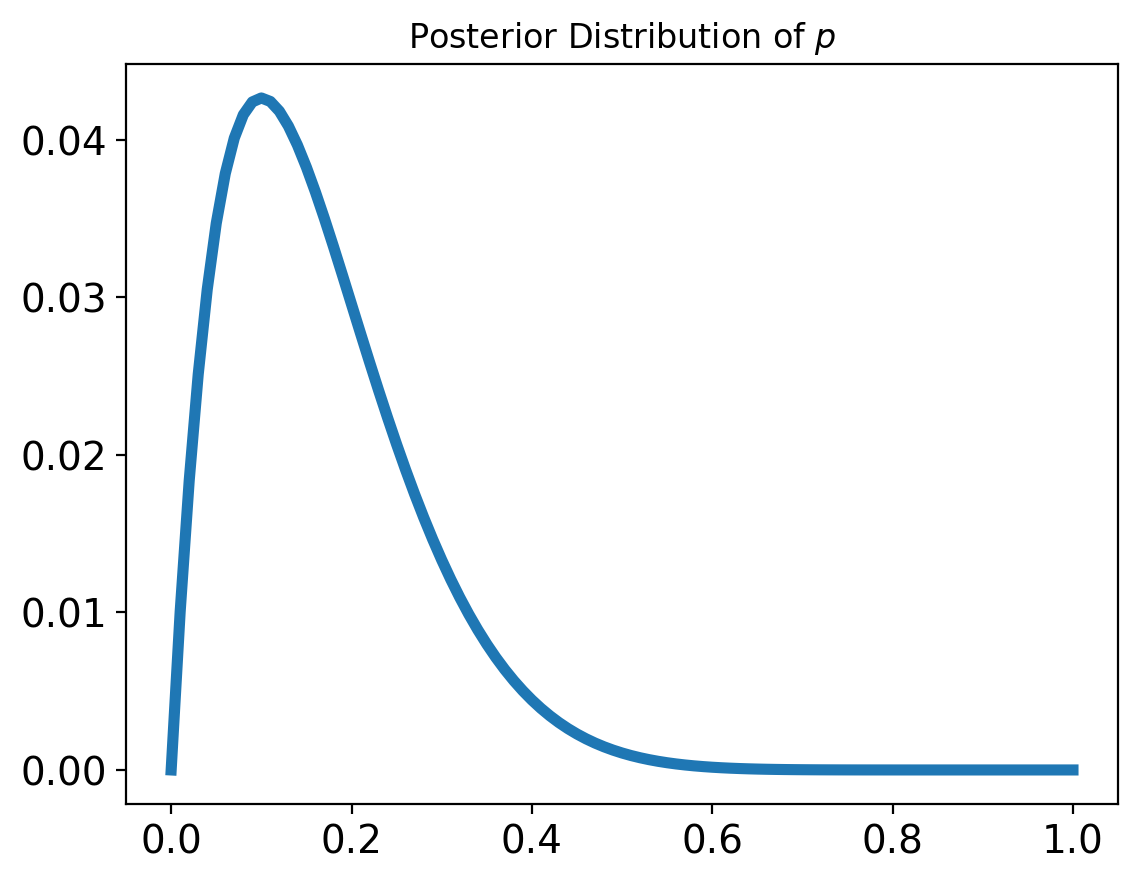

In [13]:
bandit.plot(lw = 4, legend = False, title = 'Posterior Distribution of $p$', fontsize = 14);

### Multiple Bandits

So now let's go back to our four machines. Let's say each has some different probability of actually winning (though of course these probabilities are unknown to us).

In [14]:
actual_probs = [0.10, 0.20, 0.30, 0.40]

from collections import Counter

# count how many times we've played each machine
counter = Counter()

def play(i):
    """Play machine i.
    
    i: index of the machine to play
    
    returns: string 'W' or 'L'
    """
    counter[i] += 1
    p = actual_probs[i]
    if np.random.random() < p:
        return 'W'
    else:
        return 'L'

Then let's play each machine 10 times:

In [15]:
for i in range(4):
    for _ in range(10):
        outcome = play(i)
        if outcome == 'W':
            update(beliefs[i], bandit.index)
        elif outcome == 'L':
            update(beliefs[i], 1-bandit.index)
        else:
            print('Bad data!')

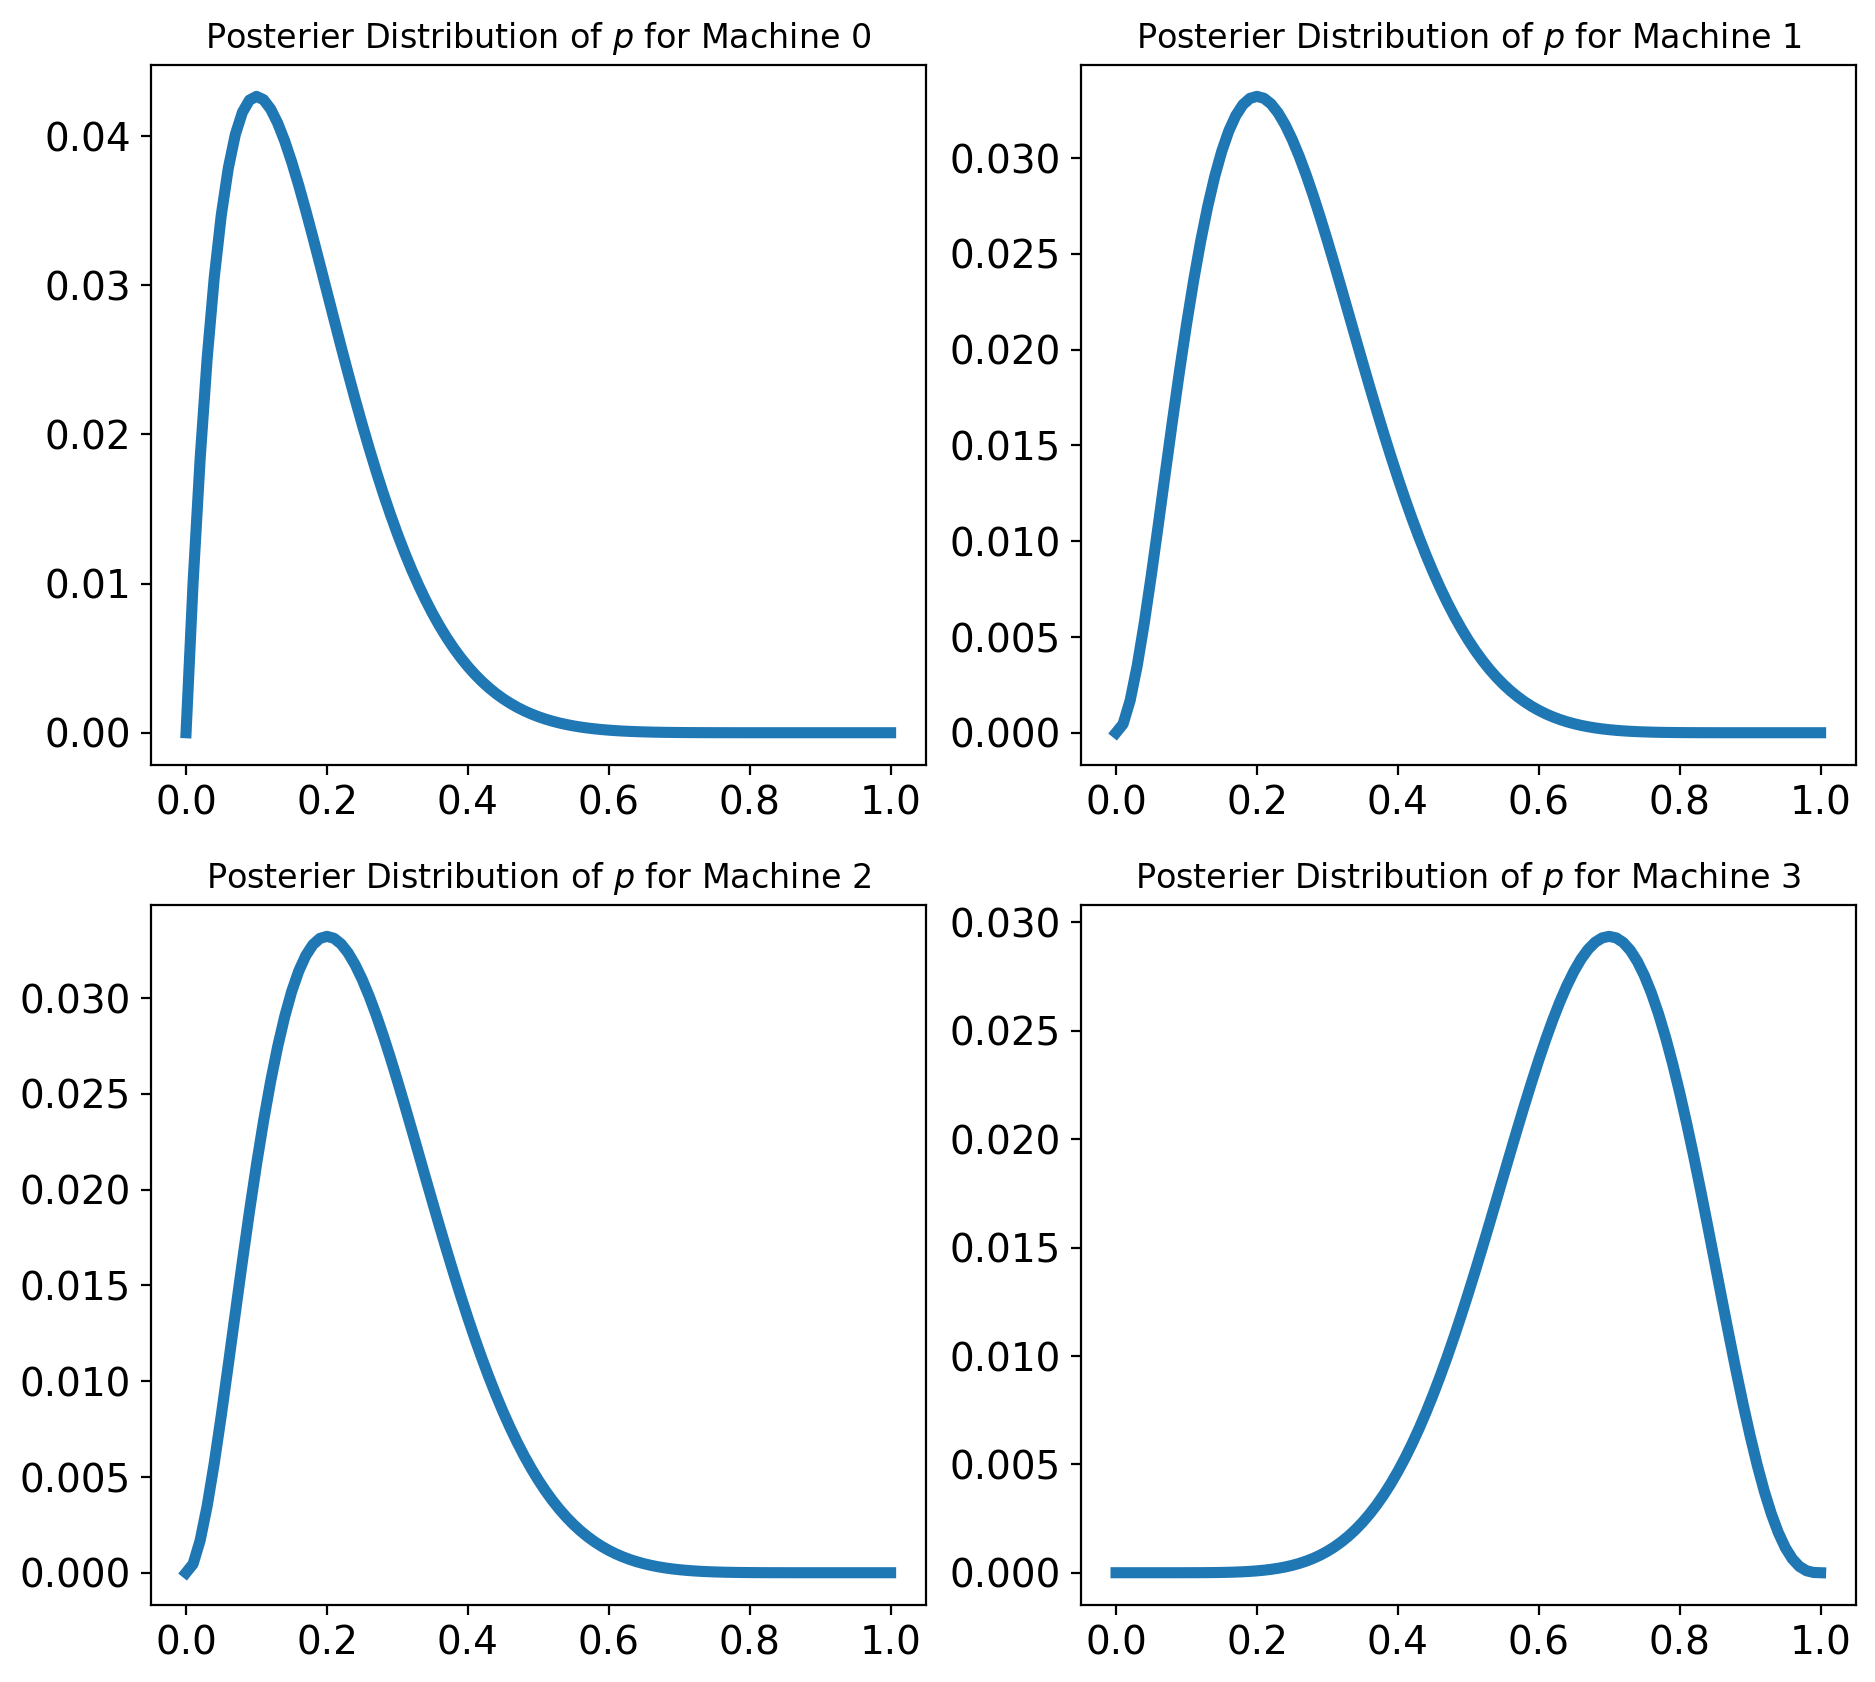

In [16]:
plt.figure(figsize=(11, 10))
for i, pmf in enumerate(beliefs):
    ax = plt.subplot(2, 2, i + 1)
    pmf.plot(ax=ax, lw = 4, legend = False, title = 'Posterier Distribution of $p$ for Machine %s' % i, fontsize = 14)

### Explore and Exploit

Based on these posterior distributions, which machine do you think we should play next? One option would be to choose the machine with the highest posterior mean.

That would not be a bad idea, but it has a drawback: since we have only played each machine a few times, the posterior distributions are wide and overlapping, which means we are not sure which machine is the best; if we focus on one machine too soon, we might choose the wrong machine and play it more than we should.

To avoid that problem, we could go to the other extreme and play all machines equally until we are confident we have identified the best machine, and then play it exclusively.

That’s not a bad idea either, but it has a drawback: while we are gathering data, we are not making good use of it; until we’re sure which machine is the best, we are playing the others more than we should.

The Bayesian Bandits strategy avoids both drawbacks by gathering and using data at the same time. In other words, it balances exploration and exploitation.

The kernel of the idea is called **Thompson sampling**: when we choose a machine, we choose at random so that the probability of choosing each machine is proportional to the probability that it is the best.

Given the posterior distributions, we can compute the “probability of superiority” for each machine.

If we draw a single random value from each posterior distribution and select the machine that yields the highest value, it turns out that we’ll select each machine in proportion to its probability of superiority.

In [17]:
def choose(beliefs):
    """Use Thompson sampling to choose a machine.
    
    Draws a single sample from each distribution.
    
    returns: index of the machine that yielded the highest value
    """
    ps = [np.random.choice(b.index,p=b['probs']) for b in beliefs]
    return np.argmax(ps)

In [18]:
choose(beliefs)

3

### The Strategy

Putting it all together, the following function chooses a machine, plays once, and updates beliefs:

In [19]:
def choose_play_update(beliefs):
    """Choose a machine, play it, and update beliefs."""
    
    # choose a machine
    machine = choose(beliefs)
    
    # play it
    outcome = play(machine)
    
    # update beliefs
    if outcome == 'W':
        update(beliefs[machine], bandit.index)
    elif outcome == 'L':
        update(beliefs[machine], 1-bandit.index)
    else:
        print('Bad data!')

In [20]:
beliefs = [p_dist.copy() for i in range(4)]
counter = Counter()

num_plays = 100

for i in range(num_plays):
    choose_play_update(beliefs)

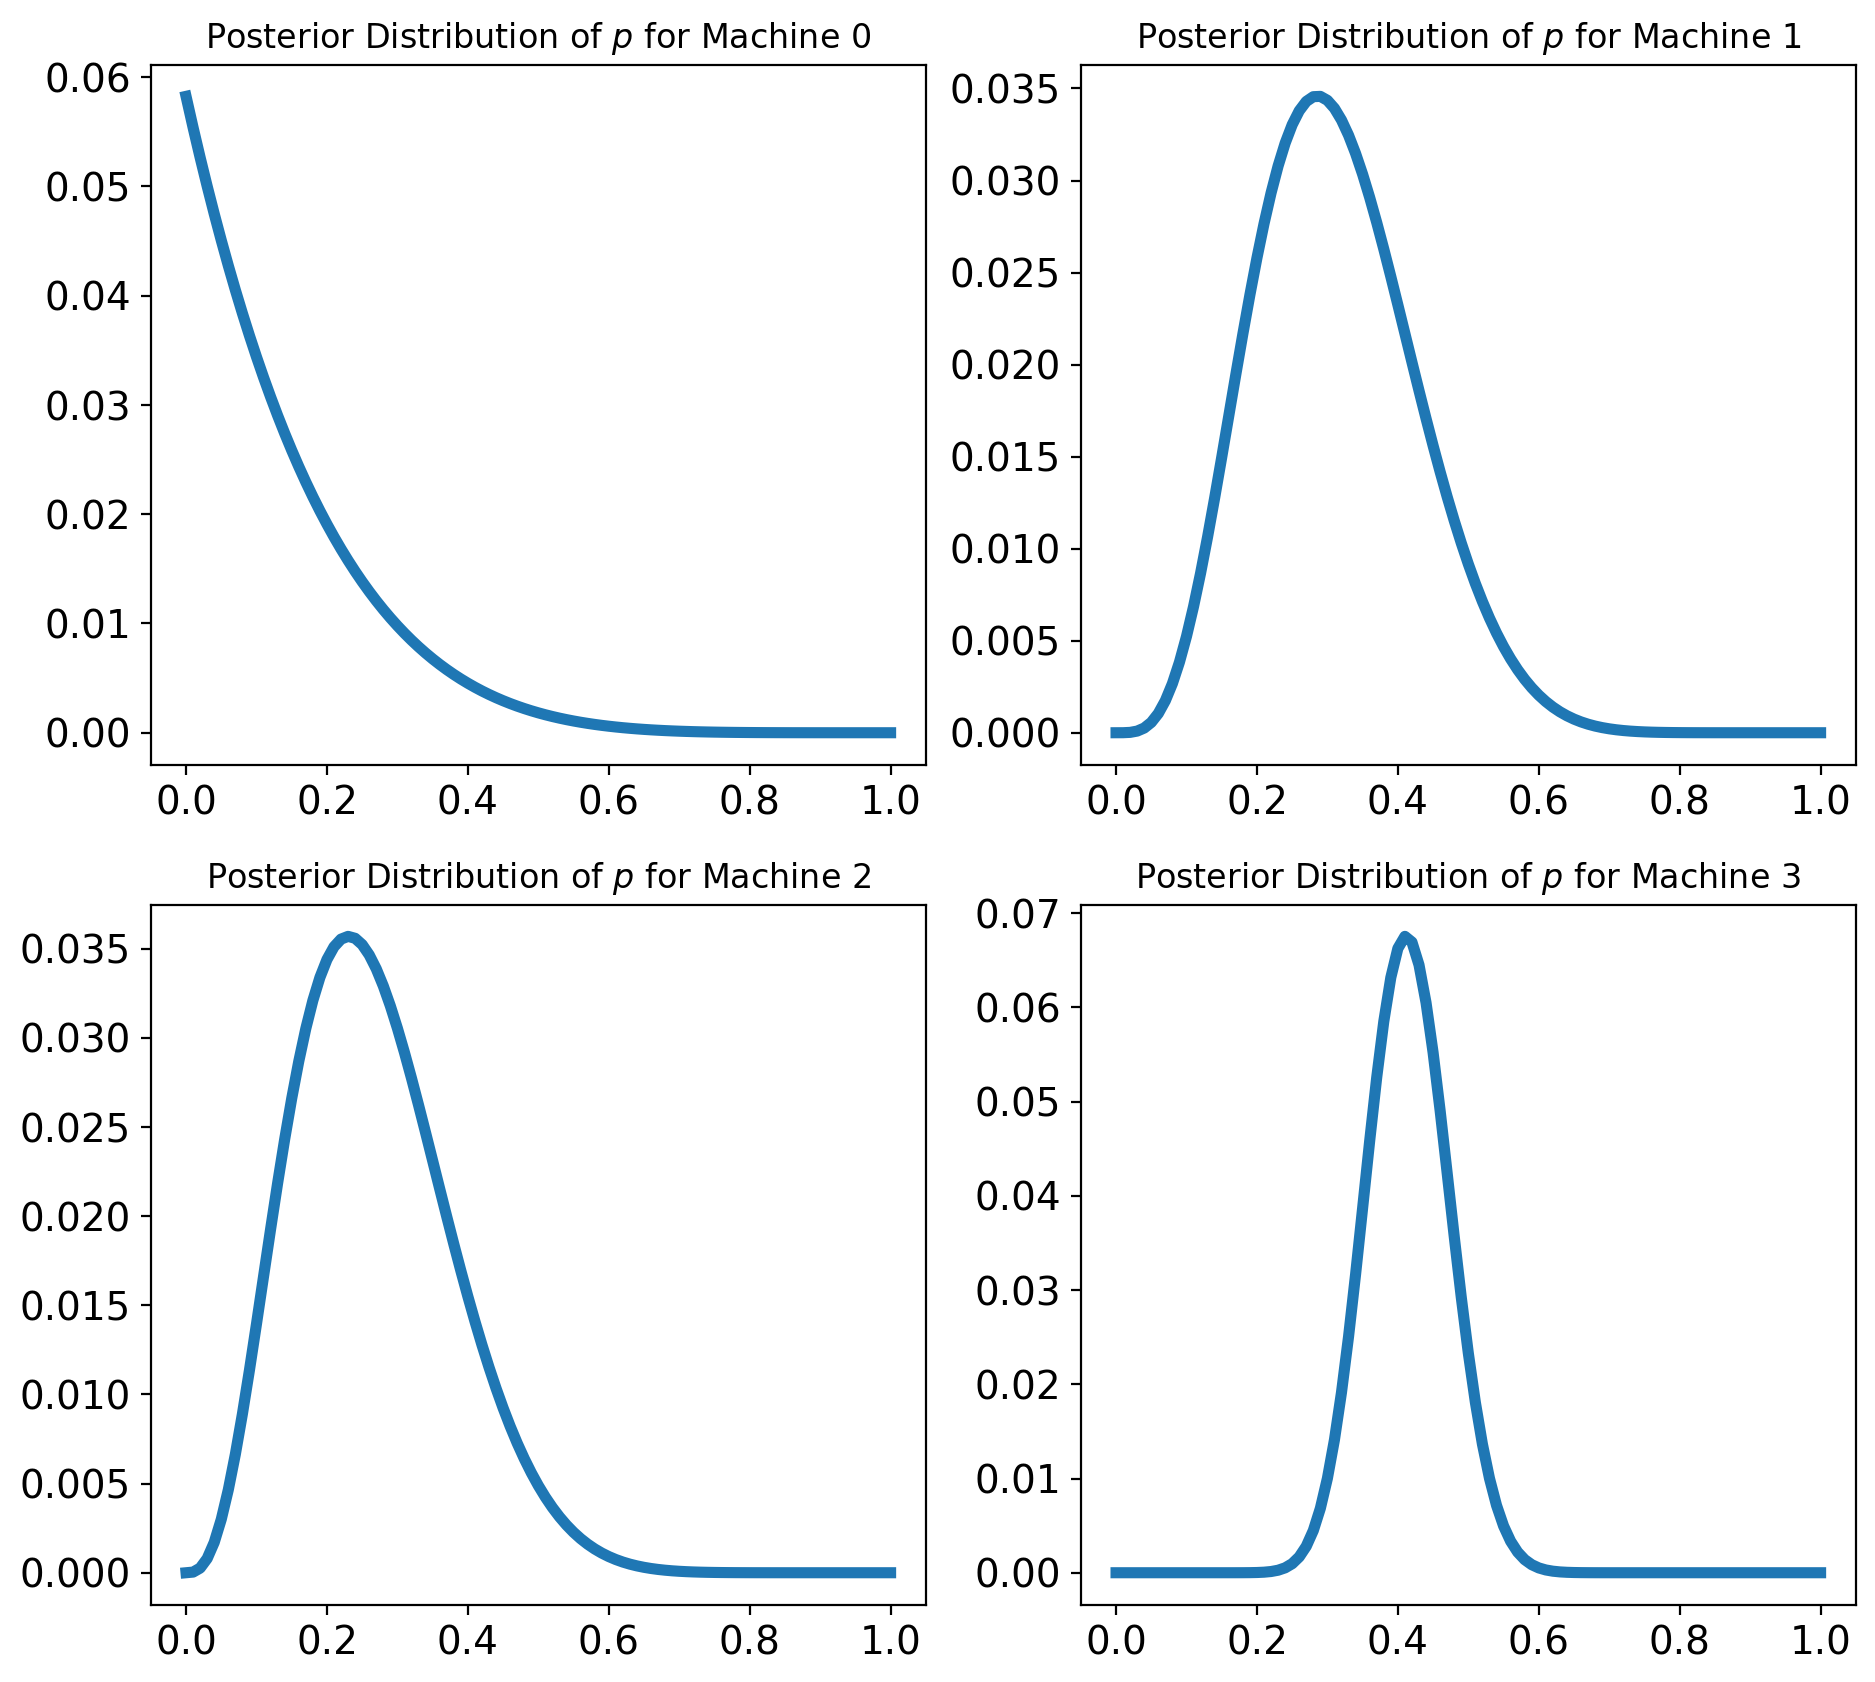

In [21]:
plt.figure(figsize=(11, 10))
for i, pmf in enumerate(beliefs):
    ax = plt.subplot(2, 2, i + 1)
    pmf.plot(ax=ax, lw = 4, legend = False, title = 'Posterior Distribution of $p$ for Machine %s' % i, fontsize = 14)

And how many times did we have to play the machines to figure this out?

In [22]:
def summarize_counter(counter):
    """Report the number of times each machine was played.
    
    counter: Collections.Counter
    
    returns: DataFrame
    """
    index = range(4)
    columns = ['Actual P(win)', 'Times played']
    df = pd.DataFrame(index=index, columns=columns)
    for i, count in counter.items():
        df.loc[i] = actual_probs[i], count
    return df

summarize_counter(counter)

,Actual P(win),Times played
0,0.1,5
1,0.2,14
2,0.3,13
3,0.4,68


So we see we played the better machines more to get more accurate estimates of their win rate!

In the end, we used our predictions about each machine to make better decisions about which machine to play.